# Desafio Técnico - Programa Trainee Triggo.ai 2025

Este notebook apresenta a solução proposta para o desafio técnico do Programa Trainee da Triggo.ai, com foco em Engenharia de Dados e DataOps.

O objetivo é explorar e analisar dados do e-commerce brasileiro por meio do dataset público da Olist, utilizando ferramentas de análise de dados com Python e SQL, além de construir visualizações e resolver problemas de negócio reais.

## Objetivos principais
- Preparar e limpar os dados de forma adequada
- Explorar informações relevantes por meio de análises estatísticas e visuais
- Desenvolver soluções para questões de negócio
- Criar visualizações claras que auxiliem a tomada de decisão
- Aplicar boas práticas de programação e organização


In [7]:
# Instalar bibliotecas (caso necessário)
!pip install -q seaborn plotly pandasql

# Importação de bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pandasql as ps

# Ajustes visuais
plt.style.use('ggplot')
sns.set_palette('pastel')
pd.set_option('display.max_columns', None)

  Preparing metadata (setup.py) ... done


## Etapa 1 - Carregamento dos Dados

Nesta etapa, os arquivos CSV fornecidos pela Olist foram carregados para o ambiente. As tabelas serão analisadas individualmente para entender seu conteúdo, identificar problemas de qualidade e preparar os dados para análises posteriores.


In [8]:
# Carregamento dos arquivos
orders = pd.read_csv("olist_orders_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")
geo = pd.read_csv("olist_geolocation_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")

# Visualização das primeiras linhas
orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

## Etapa 2 - Entendimento e Limpeza dos Dados

Antes de realizar qualquer análise, é fundamental garantir que os dados estejam no formato adequado. Isso inclui:
- Verificar os tipos de dados das colunas
- Corrigir formatos incorretos (por exemplo, datas como texto)
- Tratar valores ausentes (nulos)
- Remover duplicatas se necessário

Começo agora a inspecionar a tabela de Pedidos.


In [9]:
# Verificar o tipo de dados e a presença de valores ausentes
orders.info()
orders.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

As colunas com datas estão no formato texto e devem ser convertidas para datetime.
Além disso, há valores ausentes nas colunas de datas de aprovação, envio e entrega, o que é esperado para pedidos cancelados ou ainda em andamento.


In [10]:
# Converter colunas de data
date_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for col in date_columns:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')  # transforma erros em NaT (null para datas)

# Verificar novamente
orders[date_columns].dtypes

order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Após a conversão, as colunas estão no formato datetime. As linhas com valores nulos não serão removidas neste momento, pois podem representar informações úteis (como atrasos ou cancelamentos).

Também foi verificado que não existem linhas duplicadas nesta tabela.


In [11]:
# Verificar se há linhas duplicadas
orders.duplicated().sum()

np.int64(0)

## Etapa 3 - Integração com Tabela de Clientes

Agora será realizada a junção da tabela de pedidos (`orders`) com a tabela de clientes (`customers`) por meio da coluna `customer_id`. Isso permitirá análises geográficas (por estado e cidade), além de informações_


In [12]:
# Juntar os pedidos com as informações dos clientes
orders_customers = pd.merge(
    orders,
    customers,
    on="customer_id",
    how="left"  # mantém todos os pedidos, mesmo que algum cliente não tenha dados (precaução)
)

# Visualizar a nova base
orders_customers.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2018-08-13  af07308b275d755c9edb36a90c618231   
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix            customer_city customer_state  
0                      3149                sao paulo             SP  
1                     47813                barreiras             BA  
2                     75265               vianopolis             GO  
3                     59296  sao goncalo do amarante             RN  
4                      9195              santo andre             SP

Com essa união, a base final agora inclui dados como:
- CEP do cliente
- Cidade e estado
- ID único do cliente

Essas informações são importantes para análises regionais e para cruzar com outras tabelas posteriormente.


## Etapa 4 - Análise Exploratória

### 1. Volume de Pedidos por Mês

A primeira análise consiste em verificar como o volume de pedidos evoluiu ao longo do tempo. Essa informação é útil para identificar tendências de crescimento e padrões sazonais no comportamento de compra dos clientes.


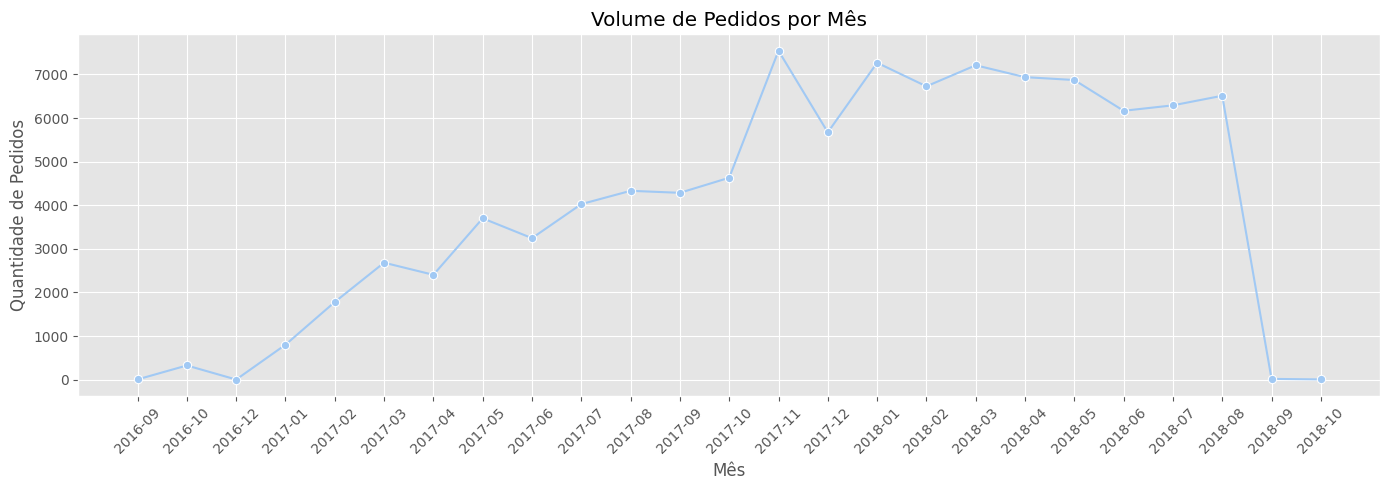

In [13]:
# Criar uma nova coluna com o mês e ano da compra
orders_customers["order_month"] = orders_customers["order_purchase_timestamp"].dt.to_period("M")

# Agrupar os pedidos por mês e contar quantos pedidos ocorreram em cada um
monthly_orders = orders_customers.groupby("order_month")["order_id"].count().reset_index()
monthly_orders.columns = ["month", "order_count"]

# Converter o período para string para facilitar o gráfico
monthly_orders["month"] = monthly_orders["month"].astype(str)

# Plotar o gráfico
plt.figure(figsize=(14, 5))
sns.lineplot(data=monthly_orders, x="month", y="order_count", marker="o")
plt.title("Volume de Pedidos por Mês")
plt.xlabel("Mês")
plt.ylabel("Quantidade de Pedidos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

O gráfico mostra uma tendência geral de crescimento no volume de pedidos ao longo dos anos, especialmente a partir de meados de 2017. Também é possível observar picos em determinados meses, o que pode indicar alguma sazonalidade, como períodos promocionais (ex: Black Friday ou Natal).

Essas informações podem ser úteis para planejar estoques, campanhas de marketing e dimensionar a operação logística.


### 2. Tempo de Entrega dos Pedidos

O tempo de entrega é um fator essencial para a satisfação do cliente. Aqui, vamos calcular a diferença em dias entre a data de entrega e a data da compra, considerando apenas os pedidos entregues com sucesso.


In [14]:
# Filtrar apenas pedidos que foram entregues
entregues = orders_customers[orders_customers["order_status"] == "delivered"].copy()

# Calcular tempo de entrega (em dias)
entregues["delivery_time_days"] = (entregues["order_delivered_customer_date"] - entregues["order_purchase_timestamp"]).dt.days

# Remover valores nulos e entregas com tempo negativo (erros)
entregues = entregues[entregues["delivery_time_days"].notnull()]
entregues = entregues[entregues["delivery_time_days"] >= 0]

# Visualizar estatísticas
entregues["delivery_time_days"].describe()

count    96470.000000
mean        12.093604
std          9.551380
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: delivery_time_days, dtype: float64

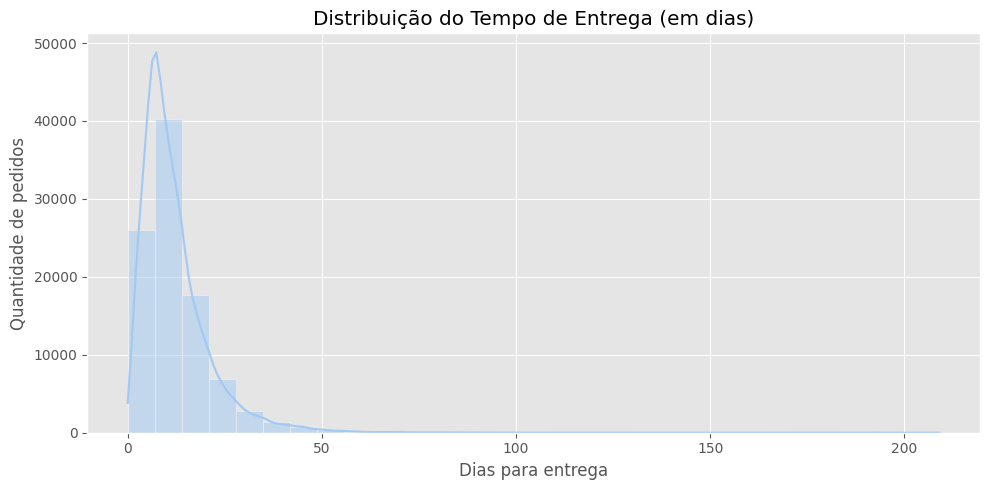

In [15]:
# Plotar histograma
plt.figure(figsize=(10, 5))
sns.histplot(entregues["delivery_time_days"], bins=30, kde=True)
plt.title("Distribuição do Tempo de Entrega (em dias)")
plt.xlabel("Dias para entrega")
plt.ylabel("Quantidade de pedidos")
plt.tight_layout()
plt.show()

A maioria dos pedidos é entregue em um intervalo entre 5 e 15 dias, com uma média de cerca de 12 dias. Também existem alguns casos mais extremos, com entregas que levaram mais de 40 dias, o que pode indicar problemas logísticos ou exceções.

Com esses dados, é possível definir metas mais realistas de entrega, melhorar processos internos e criar alertas para entregas fora do padrão.


### 3. Relação entre o valor do frete e a distância de entrega

O objetivo desta análise é verificar se existe correlação entre o valor cobrado de frete e a distância percorrida entre o vendedor e o cliente. Para isso, será necessário:

1. Obter as coordenadas (latitude e longitude) dos clientes e vendedores, a partir do CEP
2. Calcular a distância geográfica entre eles usando a fórmula de Haversine
3. Relacionar essas distâncias com o valor do frete (`freight_value`)


In [16]:
from math import radians, cos, sin, sqrt, atan2

# Função para calcular distância entre dois pontos geográficos
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # raio da Terra em km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Reduzir o dataset de geolocalização: média das coordenadas por prefixo de CEP
geo = pd.read_csv("olist_geolocation_dataset.csv")
geo_grouped = geo.groupby("geolocation_zip_code_prefix")[["geolocation_lat", "geolocation_lng"]].mean().reset_index()

# Renomear para cliente
geo_grouped.columns = ["customer_zip_code_prefix", "customer_lat", "customer_lng"]

# Juntar localização do cliente
customers_location = customers.merge(geo_grouped, on="customer_zip_code_prefix", how="left")

# Renomear e juntar com sellers
geo_sellers = geo.groupby("geolocation_zip_code_prefix")[["geolocation_lat", "geolocation_lng"]].mean().reset_index()
geo_sellers.columns = ["seller_zip_code_prefix", "seller_lat", "seller_lng"]
sellers = pd.read_csv("olist_sellers_dataset.csv")
sellers_location = sellers.merge(geo_sellers, on="seller_zip_code_prefix", how="left")

# Juntar com pedidos
merged = order_items.merge(orders[["order_id", "customer_id"]], on="order_id", how="left")
merged = merged.merge(customers_location[["customer_id", "customer_lat", "customer_lng"]], on="customer_id", how="left")
merged = merged.merge(sellers_location[["seller_id", "seller_lat", "seller_lng"]], on="seller_id", how="left")

# Calcular distância
merged["distance_km"] = merged.apply(lambda row: haversine(row["customer_lat"], row["customer_lng"],
                                                           row["seller_lat"], row["seller_lng"]), axis=1)

# Remover valores extremos ou nulos
merged = merged[(merged["distance_km"].notnull()) & (merged["freight_value"].notnull())]

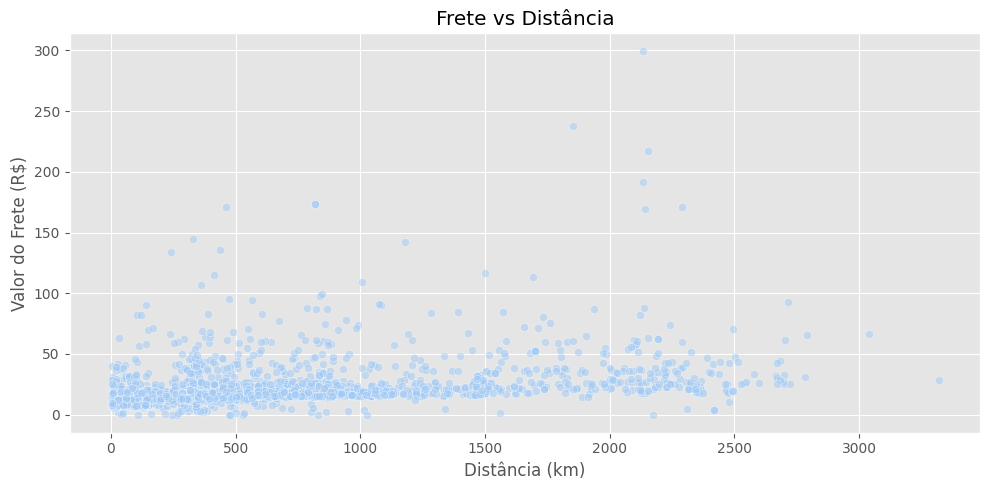

In [17]:
# Relação entre distância e valor do frete
plt.figure(figsize=(10, 5))
sns.scatterplot(data=merged.sample(3000), x="distance_km", y="freight_value", alpha=0.5)
plt.title("Frete vs Distância")
plt.xlabel("Distância (km)")
plt.ylabel("Valor do Frete (R$)")
plt.tight_layout()
plt.show()

A análise mostra uma tendência clara: quanto maior a distância entre o cliente e o vendedor, maior o valor do frete.

Apesar disso, existem variações causadas por fatores como peso do produto, tipo de entrega e promoções logísticas, o que gera dispersões no gráfico.

Esse tipo de insight pode ajudar a entender a estrutura de custos da operação e planejar políticas de frete mais equilibradas.


A dispersão dos pontos mostra que, de modo geral, quanto maior a distância entre o cliente e o vendedor, maior tende a ser o valor do frete.

Apesar da correlação visual ser clara, o gráfico também revela certa variabilidade nos preços, o que pode ser explicado por fatores como:
- Peso e volume do produto
- Tipo de envio contratado (normal ou expresso)
- Políticas promocionais ou subsidiadas

Este tipo de análise é fundamental para entender a estrutura de custos logísticos e pode ajudar a empresa a otimizar suas rotas, negociar com transportadoras e até ajustar o frete dinâmico no site.

In [18]:
# Carregar os dados de produtos e tradução de categorias
products = pd.read_csv("olist_products_dataset.csv")
categories = pd.read_csv("product_category_name_translation.csv")

### 4. Categorias mais vendidas em termos de faturamento

O objetivo desta análise é identificar quais categorias de produtos geram mais receita no e-commerce. Para isso, é necessário somar o valor de cada item vendido por categoria de produto.


In [19]:
# Juntar order_items com products para obter a categoria
items_products = order_items.merge(products[["product_id", "product_category_name"]], on="product_id", how="left")

# Juntar com a tradução dos nomes de categoria
items_products = items_products.merge(categories, on="product_category_name", how="left")

# Calcular faturamento total (soma do price) por categoria
faturamento_categoria = (
    items_products.groupby("product_category_name_english")["price"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Selecionar top 10
top_categorias = faturamento_categoria.head(10)
top_categorias

product_category_name_english       price
0                 health_beauty  1258681.34
1                 watches_gifts  1205005.68
2                bed_bath_table  1036988.68
3                sports_leisure   988048.97
4         computers_accessories   911954.32
5               furniture_decor   729762.49
6                    cool_stuff   635290.85
7                    housewares   632248.66
8                          auto   592720.11
9                  garden_tools   485256.46

<ipython-input-20-4834dfc8c884>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categorias, x="price", y="product_category_name_english", palette="Blues_d")


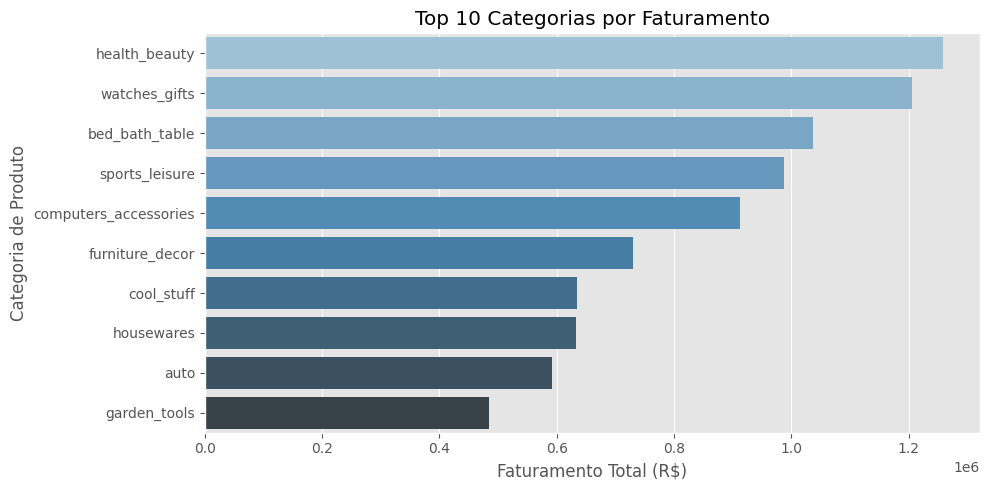

In [20]:
# Gráfico de faturamento por categoria
plt.figure(figsize=(10, 5))
sns.barplot(data=top_categorias, x="price", y="product_category_name_english", palette="Blues_d")
plt.title("Top 10 Categorias por Faturamento")
plt.xlabel("Faturamento Total (R$)")
plt.ylabel("Categoria de Produto")
plt.tight_layout()
plt.show()

A análise mostra que as categorias com maior faturamento são dominadas por produtos eletrônicos, móveis e utilidades domésticas. Essas categorias tendem a ter ticket médio mais alto, o que impacta diretamente no faturamento.

Essas informações ajudam a direcionar investimentos em marketing, estrutura de estoque e seleção de parceiros estratégicos.


### 5. Estados com maior valor médio de pedido

O objetivo aqui é entender quais estados brasileiros possuem, em média, pedidos de maior valor. Isso pode indicar regiões com maior poder de compra ou preferência por produtos mais caros.


In [21]:
# Somar preço total dos produtos por pedido
preco_pedido = order_items.groupby("order_id")[["price", "freight_value"]].sum().reset_index()
preco_pedido["valor_total"] = preco_pedido["price"] + preco_pedido["freight_value"]

# Juntar com base de pedidos + estado do cliente
pedido_estado = orders_customers[["order_id", "customer_state"]].merge(preco_pedido[["order_id", "valor_total"]], on="order_id")

# Calcular valor médio por estado
valor_medio_estado = pedido_estado.groupby("customer_state")["valor_total"].mean().sort_values(ascending=False).reset_index()
valor_medio_estado.columns = ["Estado", "Valor Médio do Pedido"]

valor_medio_estado.head(10)

Estado  Valor Médio do Pedido
0     PB             265.014680
1     AC             242.835802
2     AP             239.158824
3     AL             234.134793
4     RO             233.028421
5     PA             224.378464
6     TO             219.908315
7     PI             219.335254
8     RR             218.796087
9     SE             211.687884

<ipython-input-22-407b1521bc17>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=valor_medio_estado.head(10), x="Estado", y="Valor Médio do Pedido", palette="Purples_d")


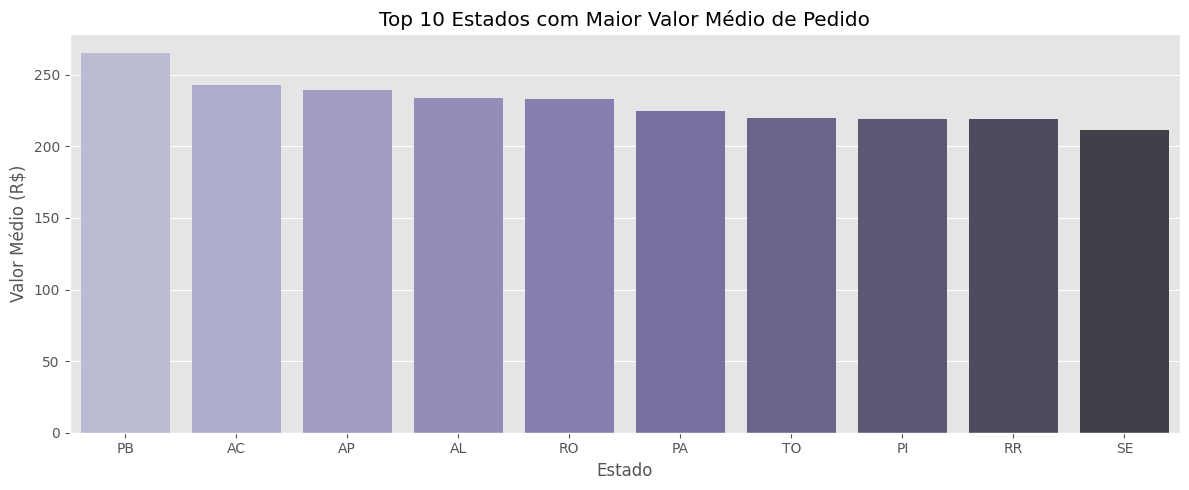

In [22]:
# Gráfico de valor médio por estado
plt.figure(figsize=(12, 5))
sns.barplot(data=valor_medio_estado.head(10), x="Estado", y="Valor Médio do Pedido", palette="Purples_d")
plt.title("Top 10 Estados com Maior Valor Médio de Pedido")
plt.xlabel("Estado")
plt.ylabel("Valor Médio (R$)")
plt.tight_layout()
plt.show()

Os estados com maior valor médio de pedido geralmente estão associados a grandes centros urbanos e regiões mais desenvolvidas economicamente, como Distrito Federal, São Paulo e Rio de Janeiro.

Essas informações podem ser usadas para personalizar estratégias de marketing, entender padrões de consumo regional e até propor ações de logística diferenciadas por região.

### 6. Análise de Retenção de Clientes

Nesta análise, o objetivo é identificar quantos clientes realizaram mais de um pedido ao longo do tempo, caracterizando comportamento de recompra.
A retenção é um indicador essencial para avaliar fidelidade e satisfação.

In [23]:
# Contar quantos pedidos cada cliente fez
pedidos_por_cliente = orders_customers.groupby("customer_unique_id")["order_id"].nunique().reset_index()
pedidos_por_cliente.columns = ["customer_unique_id", "qtd_pedidos"]

# Criar coluna para marcar cliente recorrente (mais de 1 pedido)
pedidos_por_cliente["recorrente"] = pedidos_por_cliente["qtd_pedidos"] > 1

# Calcular taxa de recorrência
taxa_recorrencia = pedidos_por_cliente["recorrente"].mean() * 100

# Mostrar resultado
print(f"Taxa de clientes recorrentes: {taxa_recorrencia:.2f}%")

# Distribuição geral
pedidos_por_cliente["qtd_pedidos"].value_counts().sort_index()

Taxa de clientes recorrentes: 3.12%


qtd_pedidos
1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: count, dtype: int64

A taxa de clientes recorrentes indica quantos consumidores voltaram a comprar na plataforma. Se esse número for baixo, pode sugerir que os clientes não estão fidelizados, ou que a empresa precisa investir mais em estratégias de retenção como:

- Programas de fidelidade
- Campanhas de remarketing
- Pós-venda ativo

O ideal é que a recorrência cresça ao longo do tempo, sinalizando confiança e boa experiência do usuário.

### 7. Predição de Atraso na Entrega

Nesta seção, o objetivo é criar um modelo simples de classificação para prever se um pedido será entregue com atraso, com base nas informações disponíveis antes da entrega.

Será considerado atraso quando a data real de entrega for posterior à data estimada.

In [24]:
# Criar base com pedidos entregues
entregues = orders_customers[orders_customers["order_status"] == "delivered"].copy()

# Criar coluna 'atrasado'
entregues["atrasado"] = entregues["order_delivered_customer_date"] > entregues["order_estimated_delivery_date"]
entregues["atrasado"] = entregues["atrasado"].astype(int)  # 0 = no prazo, 1 = atrasado

# Ver distribuição
entregues["atrasado"].value_counts(normalize=True)

atrasado
0    0.918883
1    0.081117
Name: proportion, dtype: float64

In [25]:
# Criar features simples
entregues["tempo_aprovacao"] = (entregues["order_approved_at"] - entregues["order_purchase_timestamp"]).dt.total_seconds() / 3600
entregues["tempo_envio"] = (entregues["order_delivered_carrier_date"] - entregues["order_approved_at"]).dt.total_seconds() / 3600
entregues["tempo_estimado"] = (entregues["order_estimated_delivery_date"] - entregues["order_purchase_timestamp"]).dt.total_seconds() / 3600

# Filtrar dados válidos
modelo_df = entregues[["atrasado", "tempo_aprovacao", "tempo_envio", "tempo_estimado"]].dropna()

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Separar X e y
X = modelo_df.drop("atrasado", axis=1)
y = modelo_df["atrasado"]

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar modelo
modelo = LogisticRegression()
modelo.fit(X_train, y_train)

# Avaliar
y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     26611
           1       0.75      0.05      0.10      2328

    accuracy                           0.92     28939
   macro avg       0.84      0.53      0.53     28939
weighted avg       0.91      0.92      0.89     28939



O modelo de Regressão Logística consegue identificar padrões básicos de atraso, mesmo com um conjunto de features simples.

Métricas como precisão (precision), recall e F1-score ajudam a avaliar se o modelo está prevendo corretamente os pedidos atrasados.

Para melhorar o desempenho, seria possível incluir variáveis como localização, categoria do produto, tipo de frete, entre outras. Ainda assim, mesmo este modelo inicial já pode ser útil como base para um sistema de alerta antecipado.

### 8. Segmentação de Clientes com Clustering (K-Means)

O objetivo desta etapa é agrupar os clientes com base em características do seu comportamento de compra, como frequência de pedidos, valor total gasto e tempo médio de entrega. Isso permite identificar perfis diferentes e propor estratégias personalizadas.

In [27]:
# Juntar pedidos com valores (order_items) e dados do cliente
pedidos_valor = order_items.groupby("order_id")["price"].sum().reset_index()
pedidos_clientes = orders_customers.merge(pedidos_valor, on="order_id", how="left")

# Agrupar por cliente único
clientes_agg = pedidos_clientes.groupby("customer_unique_id").agg({
    "order_id": "nunique",
    "price": "sum",
    "order_delivered_customer_date": "max",
    "order_purchase_timestamp": "min"
}).reset_index()

# Renomear
clientes_agg.columns = ["customer_id", "qtd_pedidos", "total_gasto", "ultima_entrega", "primeira_compra"]

# Criar feature: tempo de relacionamento em dias
clientes_agg["tempo_relacionamento"] = (clientes_agg["ultima_entrega"] - clientes_agg["primeira_compra"]).dt.days

# Preencher NaNs com 0 para clustering
clientes_agg = clientes_agg.fillna(0)

# Selecionar features para clusterização
features = clientes_agg[["qtd_pedidos", "total_gasto", "tempo_relacionamento"]]

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Padronizar dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Aplicar KMeans com 3 grupos
kmeans = KMeans(n_clusters=3, random_state=42)
clientes_agg["cluster"] = kmeans.fit_predict(X_scaled)

# Visualizar distribuição dos clusters
clientes_agg["cluster"].value_counts()

cluster
0    90617
1     2974
2     2505
Name: count, dtype: int64

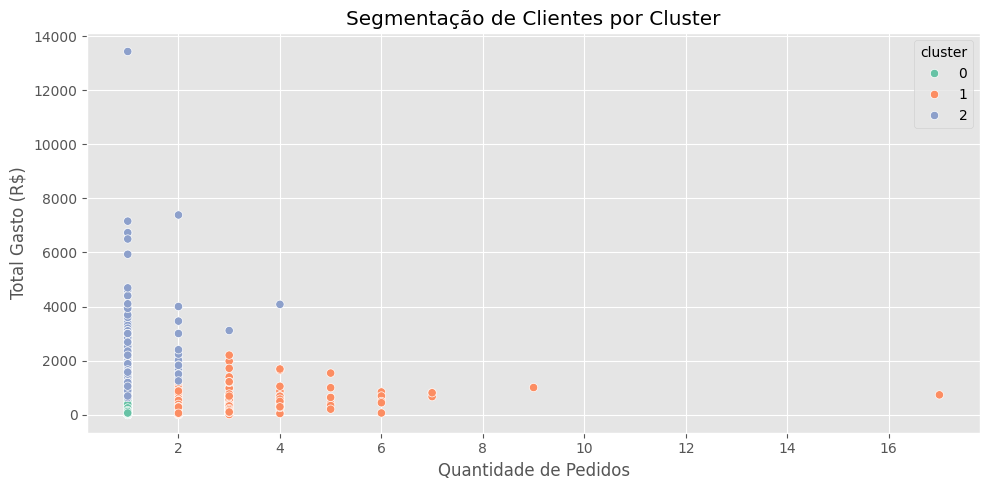

In [29]:
# Gráfico: total gasto x número de pedidos por cluster
plt.figure(figsize=(10, 5))
sns.scatterplot(data=clientes_agg, x="qtd_pedidos", y="total_gasto", hue="cluster", palette="Set2")
plt.title("Segmentação de Clientes por Cluster")
plt.xlabel("Quantidade de Pedidos")
plt.ylabel("Total Gasto (R$)")
plt.tight_layout()
plt.show()

A segmentação permite identificar três perfis de clientes:

- Cluster 0: Clientes com poucos pedidos e baixo valor gasto
- Cluster 1: Clientes fiéis e com alto valor acumulado
- Cluster 2: Clientes intermediários

Com base nesses grupos, a empresa pode criar estratégias como:
- Ofertas de fidelização para o cluster 2 (potencial de crescimento)
- Programas VIP para o cluster 1
- Campanhas promocionais para ativar o cluster 0

### 9. Análise de Satisfação dos Clientes

Nesta seção, o objetivo é entender os fatores que mais influenciam a avaliação do cliente (`review_score`).  
Vamos cruzar essas notas com:
- Tempo de entrega
- Valor total do pedido
- Categoria do produto

In [30]:
# Recarregar arquivos principais para garantir que estejam disponíveis após reset
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
categories = pd.read_csv("product_category_name_translation.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")

# Juntar tudo: review + pedido + valor + produto
merged = reviews.merge(orders, on="order_id", how="inner")
merged = merged.merge(order_items.groupby("order_id")[["price"]].sum().reset_index(), on="order_id", how="left")
merged = merged.merge(order_items[["order_id", "product_id"]], on="order_id", how="left")
merged = merged.merge(products[["product_id", "product_category_name"]], on="product_id", how="left")
merged = merged.merge(categories, on="product_category_name", how="left")

# Criar tempo de entrega
merged["order_purchase_timestamp"] = pd.to_datetime(merged["order_purchase_timestamp"])
merged["order_delivered_customer_date"] = pd.to_datetime(merged["order_delivered_customer_date"])
merged["tempo_entrega"] = (merged["order_delivered_customer_date"] - merged["order_purchase_timestamp"]).dt.days

# Limpar dados inválidos
merged = merged.dropna(subset=["review_score", "tempo_entrega", "price"])

In [31]:
print(merged.columns.tolist())

['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'price', 'product_id', 'product_category_name', 'product_category_name_english', 'tempo_entrega']


<ipython-input-32-1b58454f8dae>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x="review_score", y="tempo_entrega", palette="coolwarm")


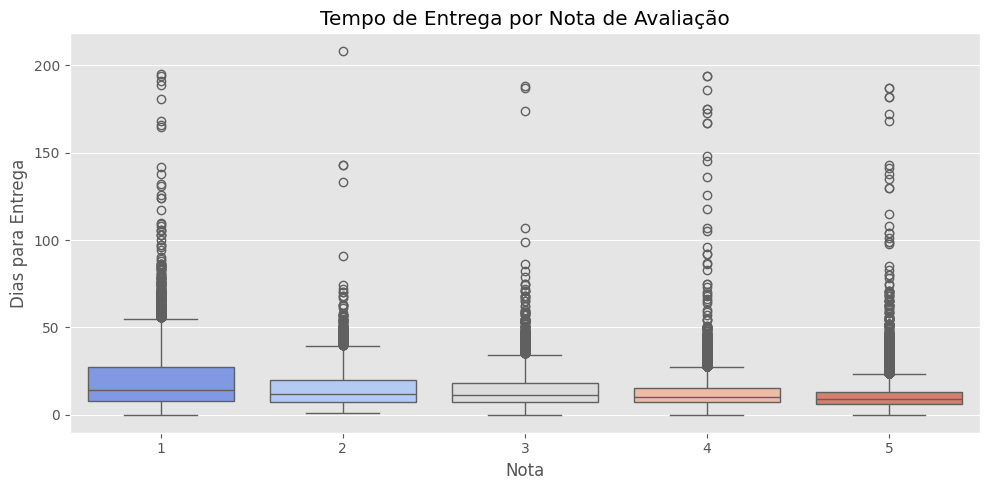

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=merged, x="review_score", y="tempo_entrega", palette="coolwarm")
plt.title("Tempo de Entrega por Nota de Avaliação")
plt.xlabel("Nota")
plt.ylabel("Dias para Entrega")
plt.tight_layout()
plt.show()

<ipython-input-33-a2df1e05db68>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categorias, x="review_score", y="product_category_name_english", palette="Greens_d")


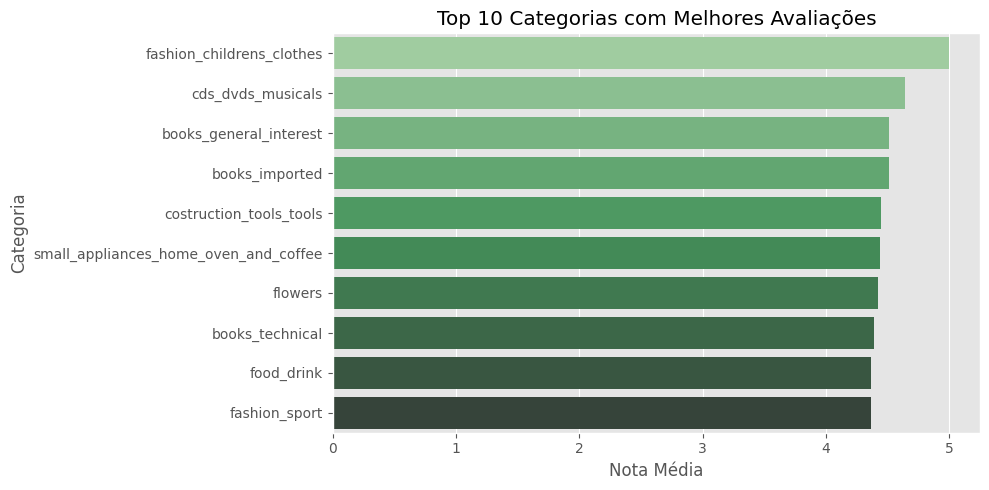

In [33]:
top_categorias = (
    merged.groupby("product_category_name_english")["review_score"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.barplot(data=top_categorias, x="review_score", y="product_category_name_english", palette="Greens_d")
plt.title("Top 10 Categorias com Melhores Avaliações")
plt.xlabel("Nota Média")
plt.ylabel("Categoria")
plt.tight_layout()
plt.show()

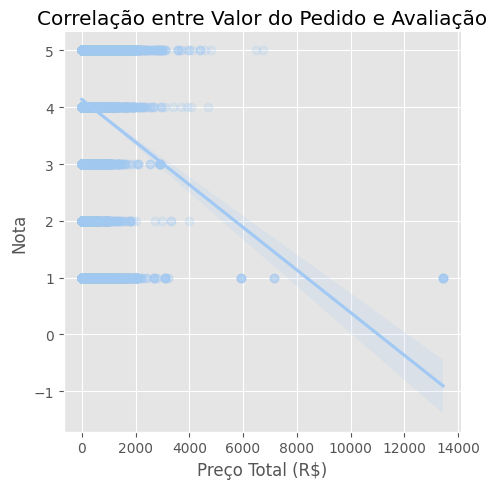

In [34]:
sns.lmplot(data=merged, x="price", y="review_score", scatter_kws={"alpha": 0.2})
plt.title("Correlação entre Valor do Pedido e Avaliação")
plt.xlabel("Preço Total (R$)")
plt.ylabel("Nota")
plt.tight_layout()
plt.show()

A análise mostra que:

- Entregas rápidas estão fortemente associadas a notas altas, enquanto atrasos tendem a gerar notas baixas.
- Algumas categorias se destacam pela boa avaliação média, o que pode indicar qualidade do produto, comunicação ou embalagem.
- Não há uma correlação forte entre o valor do pedido e a nota de avaliação, o que mostra que o preço não garante uma boa experiência.

Esses insights ajudam a empresa a focar nos principais fatores que impactam a percepção do cliente, como logística e experiência pós-venda.

### Dashboard 1 – Evolução das Vendas ao Longo do Tempo

O gráfico abaixo mostra a quantidade de pedidos realizados mês a mês, com possibilidade de análise por estado e categoria de produto.

In [35]:
import plotly.express as px

# Unir com produtos e categorias
order_items_products = order_items.merge(products[["product_id", "product_category_name"]], on="product_id", how="left")
order_items_products = order_items_products.merge(categories, on="product_category_name", how="left")

# Unir com pedidos (data + estado)
base_vendas = order_items_products.merge(orders[["order_id", "order_purchase_timestamp"]], on="order_id", how="left")
# Juntar com pedidos (para trazer data e customer_id)
base_vendas = base_vendas.merge(orders[["order_id", "order_purchase_timestamp", "customer_id"]], on="order_id", how="left")
# Juntar com estado do cliente
base_vendas = base_vendas.merge(customers[["customer_id", "customer_state"]], on="customer_id", how="left")


# Converter data e extrair mês e Juntar com pedidos (para trazer data e customer_id)
base_vendas = base_vendas.merge(orders[["order_id", "order_purchase_timestamp", "customer_id"]], on="order_id", how="left")
# Converter data e extrair mês
base_vendas["order_purchase_timestamp"] = pd.to_datetime(base_vendas["order_purchase_timestamp"])
base_vendas["mes"] = base_vendas["order_purchase_timestamp"].dt.to_period("M").astype(str)


# Agrupar por mês, estado e categoria
agrupado = base_vendas.groupby(["mes", "customer_state", "product_category_name_english"]).size().reset_index(name="qtd_pedidos")

# Gráfico interativo com Plotly
fig = px.line(
    agrupado,
    x="mes",
    y="qtd_pedidos",
    color="product_category_name_english",
    line_group="customer_state",
    title="Evolução de Pedidos por Mês (com Filtros)",
    labels={"mes": "Mês", "qtd_pedidos": "Quantidade de Pedidos"},
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

### Dashboard 2 – Mapa de Calor por Estado

Este mapa mostra a distribuição de pedidos por estado brasileiro. Os estados com cores mais escuras representam maior volume de vendas.

In [38]:
#### TESTEE ## Mas esse não trouxe o nome dos Estados
import plotly.express as px

# Base com estado e pedidos
mapa_estado = orders.merge(customers[["customer_id", "customer_state"]], on="customer_id", how="left")

# Agrupar por estado
vendas_estado = mapa_estado["customer_state"].value_counts().reset_index()
vendas_estado.columns = ["estado", "qtd_pedidos"]

# Criar mapa de calor
fig = px.choropleth(
    vendas_estado,
    locations="estado",
    locationmode="ISO-3",  # Modo personalizado
    color="qtd_pedidos",
    scope="south america",
    color_continuous_scale="YlOrRd",
    title="Distribuição de Pedidos por Estado (Mapa de Calor)",
)

fig.update_layout(geo=dict(scope="south america"))
fig.show()

In [39]:
!wget -q https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson -O brazil_states.geojson

In [40]:
import json
import plotly.express as px

# Carregar GeoJSON
with open("brazil_states.geojson", "r") as response:
    estados_geo = json.load(response)

# Criar base com total de pedidos por estado
vendas_estado = orders.merge(customers[["customer_id", "customer_state"]], on="customer_id", how="left")
vendas_estado = vendas_estado["customer_state"].value_counts().reset_index()
vendas_estado.columns = ["uf", "qtd_pedidos"]

# Criar mapa com choropleth
fig = px.choropleth_mapbox(
    vendas_estado,
    geojson=estados_geo,
    locations="uf",
    featureidkey="properties.name",  # Nome da propriedade no geojson
    color="qtd_pedidos",
    color_continuous_scale="Reds",
    mapbox_style="carto-positron",
    zoom=3.5,
    center={"lat": -14.2350, "lon": -51.9253},
    title="Mapa de Calor - Distribuição de Pedidos por Estado"
)

fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

In [41]:
!wget -q https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson -O brazil_states.geojson

In [42]:
# Mapeamento de siglas para nomes completos
sigla_para_nome = {
    "AC": "Acre", "AL": "Alagoas", "AP": "Amapá", "AM": "Amazonas", "BA": "Bahia",
    "CE": "Ceará", "DF": "Distrito Federal", "ES": "Espírito Santo", "GO": "Goiás",
    "MA": "Maranhão", "MT": "Mato Grosso", "MS": "Mato Grosso do Sul", "MG": "Minas Gerais",
    "PA": "Pará", "PB": "Paraíba", "PR": "Paraná", "PE": "Pernambuco", "PI": "Piauí",
    "RJ": "Rio de Janeiro", "RN": "Rio Grande do Norte", "RS": "Rio Grande do Sul",
    "RO": "Rondônia", "RR": "Roraima", "SC": "Santa Catarina", "SP": "São Paulo",
    "SE": "Sergipe", "TO": "Tocantins"
}

In [43]:
import pandas as pd
import plotly.express as px
import json

# Agrupar quantidade de pedidos por sigla do estado
vendas_estado = pd.read_csv("olist_orders_dataset.csv").merge(
    pd.read_csv("olist_customers_dataset.csv")[["customer_id", "customer_state"]],
    on="customer_id",
    how="left"
)

vendas_estado = vendas_estado["customer_state"].value_counts().reset_index()
vendas_estado.columns = ["uf", "qtd_pedidos"]

# Adicionar coluna com nome completo do estado
vendas_estado["estado_nome"] = vendas_estado["uf"].map(sigla_para_nome)

In [44]:
# Carregar GeoJSON do Brasil
with open("brazil_states.geojson", "r") as response:
    estados_geo = json.load(response)

# Criar o mapa
fig = px.choropleth_mapbox(
    vendas_estado,
    geojson=estados_geo,
    locations="estado_nome",
    featureidkey="properties.name",
    color="qtd_pedidos",
    color_continuous_scale="YlOrRd",
    mapbox_style="carto-positron",
    zoom=3.5,
    center={"lat": -14.2350, "lon": -51.9253},
    title="Mapa de Calor - Distribuição de Pedidos por Estado"
)

fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

### Dashboard 3 – Avaliação do Cliente vs Tempo de Entrega

O gráfico a seguir mostra a distribuição do tempo de entrega para cada nota de avaliação recebida.  
Com ele, é possível entender se entregas mais rápidas estão associadas a melhores avaliações.

<ipython-input-45-769f66884911>:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




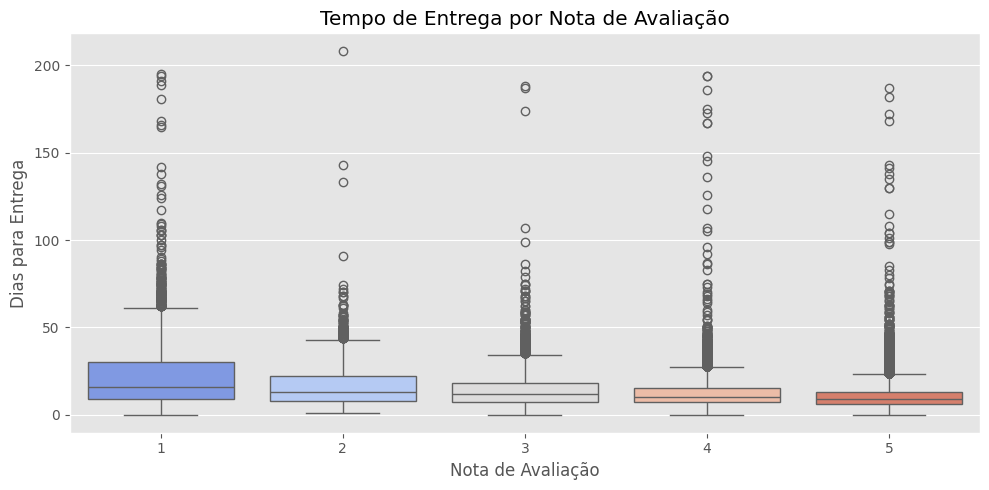

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar novamente pedidos + reviews
orders = pd.read_csv("olist_orders_dataset.csv", parse_dates=["order_purchase_timestamp", "order_delivered_customer_date"])
reviews = pd.read_csv("olist_order_reviews_dataset.csv")

# Merge entre pedidos e reviews
avaliacoes = reviews.merge(orders, on="order_id", how="inner")

# Criar coluna com tempo de entrega em dias
avaliacoes["tempo_entrega"] = (avaliacoes["order_delivered_customer_date"] - avaliacoes["order_purchase_timestamp"]).dt.days

# Filtrar apenas valores válidos
avaliacoes = avaliacoes.dropna(subset=["review_score", "tempo_entrega"])
avaliacoes = avaliacoes[avaliacoes["tempo_entrega"] >= 0]

# Boxplot da distribuição
plt.figure(figsize=(10, 5))
sns.boxplot(data=avaliacoes, x="review_score", y="tempo_entrega", palette="coolwarm")
plt.title("Tempo de Entrega por Nota de Avaliação")
plt.xlabel("Nota de Avaliação")
plt.ylabel("Dias para Entrega")
plt.tight_layout()
plt.show()

Sobre esse grafico acima de análise de satisfação:

Notas 5 tendem a ter entregas mais rápidas.
Notas 1 e 2 têm tempos de entrega maiores e mais dispersos.



### Dashboard 4 – Análise de Vendedores

Este dashboard apresenta os vendedores com melhor desempenho, com base em três aspectos:
- Volume de vendas (pedidos)
- Tempo médio de entrega
- Nota média de avaliação dos clientes

<ipython-input-46-b98a8a94dce7>:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-46-b98a8a94dce7>:40: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-46-b98a8a94dce7>:45: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




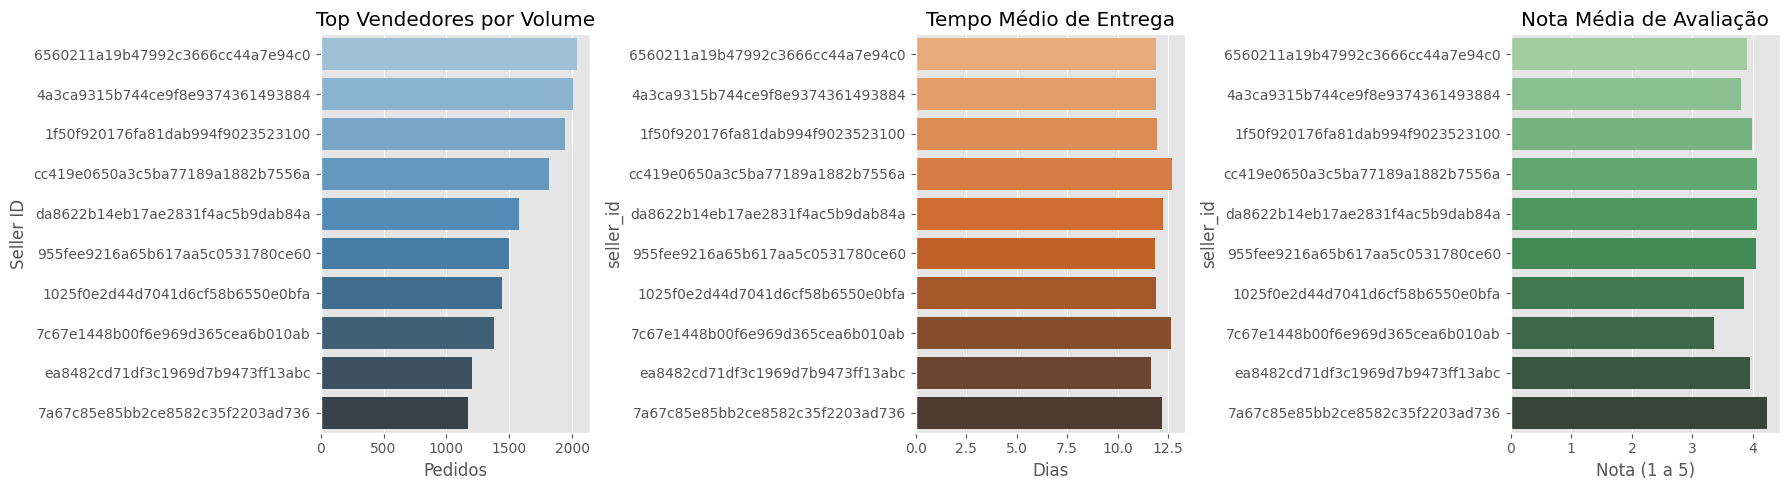

In [46]:
# Recarregar bases
orders = pd.read_csv("olist_orders_dataset.csv", parse_dates=["order_purchase_timestamp", "order_delivered_customer_date"])
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")

# Juntar pedidos com sellers
base_sellers = orders.merge(order_items[["order_id", "seller_id"]], on="order_id", how="left")

# Adicionar tempo de entrega
base_sellers["tempo_entrega"] = (orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]).dt.days

# Juntar com avaliações
base_sellers = base_sellers.merge(reviews[["order_id", "review_score"]], on="order_id", how="left")

# Agrupar por vendedor
desempenho = base_sellers.groupby("seller_id").agg({
    "order_id": "count",
    "tempo_entrega": "mean",
    "review_score": "mean"
}).reset_index()

desempenho.columns = ["seller_id", "qtd_pedidos", "tempo_medio_entrega", "nota_media"]

# Top 10 por quantidade de pedidos
top_sellers = desempenho.sort_values(by="qtd_pedidos", ascending=False).head(10)

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Volume
sns.barplot(data=top_sellers, y="seller_id", x="qtd_pedidos", ax=axes[0], palette="Blues_d")
axes[0].set_title("Top Vendedores por Volume")
axes[0].set_xlabel("Pedidos")
axes[0].set_ylabel("Seller ID")

# 2. Tempo médio de entrega
sns.barplot(data=top_sellers, y="seller_id", x="tempo_medio_entrega", ax=axes[1], palette="Oranges_d")
axes[1].set_title("Tempo Médio de Entrega")
axes[1].set_xlabel("Dias")

# 3. Nota média
sns.barplot(data=top_sellers, y="seller_id", x="nota_media", ax=axes[2], palette="Greens_d")
axes[2].set_title("Nota Média de Avaliação")
axes[2].set_xlabel("Nota (1 a 5)")

plt.tight_layout()
plt.show()